## Fashion MNIST Classification project - Deep Learning Models Implementation

In [29]:
#Checking the gpu availability in mac for using torch
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [30]:
#Importing the dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import seaborn as sns

import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

## Loading the FashionMNIST

In [31]:
# Load the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [32]:
# K-fold cross-validation
k_folds = 3
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

### ANN (Artifical Neural Network)

In [33]:
# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.normalize = nn.BatchNorm1d(28 * 28)  # Assuming input size is 28x28
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, 10)  # Output layer with 10 classes
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, x):
        x = self.flatten(x)
        x = self.normalize(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

In [34]:
# K-fold cross-validation loop
n_epochs = 100
epoch_end = []
kf_losses = {'train': [[] for _ in range(k_folds)], 'val': [[] for _ in range(k_folds)]}
kf_accuracy = {'train': [[] for _ in range(k_folds)], 'val': [[] for _ in range(k_folds)]} #Accuracy dictionary 

for fold, (train_indices, val_indices) in enumerate(kf.split(full_train_dataset)):
    train_fold_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
    val_fold_dataset = torch.utils.data.Subset(full_train_dataset, val_indices)

    train_fold_loader = DataLoader(train_fold_dataset, batch_size=64, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=64, shuffle=False)

    # Instantiate the model, loss function, and optimizer
    model = ANN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = {'train': [], 'val': []}

    patience = 10
    counter = 0 
    best_validation_loss = float('inf')  


    for epoch in range(n_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0

        for images, labels in train_fold_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_accuracy = train_correct / train_total    
        average_train_loss = epoch_loss / len(train_fold_loader)
        epoch_losses['train'].append(average_train_loss)

        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        

        with torch.no_grad():
            for images, labels in val_fold_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()


            val_accuracy = val_correct / val_total

            average_val_loss = val_loss / len(val_fold_loader)
            epoch_losses['val'].append(average_val_loss)

        if average_val_loss < best_validation_loss:
            best_validation_loss = average_val_loss
            k = 'Best_Models/ANN/'+'best_model_' + str(fold)
            torch.save(model.state_dict(), f'{k}.pth')
            counter = 0 
        else:
            counter +=1 
        

        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            epoch_end.append(epoch)
            break

        if (epoch+1) == n_epochs:
            epoch_end.append(epoch)


        print(f'Fold {fold + 1}, Epoch {epoch + 1}/{n_epochs}, Train Loss: {average_train_loss:.4f}, Train accuracy: {train_accuracy:.4f},  Val Loss: {average_val_loss:.4f},  Validation accuracy: {val_accuracy:.4f}, Counter: {counter}')

    kf_losses['train'][fold] = epoch_losses['train']
    kf_losses['val'][fold] = epoch_losses['val']

Fold 1, Epoch 1/100, Train Loss: 1.6994, Train accuracy: 0.7696,  Val Loss: 1.6591,  Validation accuracy: 0.8025, Counter: 0
Fold 1, Epoch 2/100, Train Loss: 1.6441, Train accuracy: 0.8175,  Val Loss: 1.6157,  Validation accuracy: 0.8452, Counter: 0
Fold 1, Epoch 3/100, Train Loss: 1.6154, Train accuracy: 0.8458,  Val Loss: 1.6171,  Validation accuracy: 0.8433, Counter: 1
Fold 1, Epoch 4/100, Train Loss: 1.6051, Train accuracy: 0.8563,  Val Loss: 1.6187,  Validation accuracy: 0.8424, Counter: 2
Fold 1, Epoch 5/100, Train Loss: 1.5992, Train accuracy: 0.8615,  Val Loss: 1.5978,  Validation accuracy: 0.8634, Counter: 0
Fold 1, Epoch 6/100, Train Loss: 1.5945, Train accuracy: 0.8668,  Val Loss: 1.5933,  Validation accuracy: 0.8671, Counter: 0
Fold 1, Epoch 7/100, Train Loss: 1.5896, Train accuracy: 0.8712,  Val Loss: 1.5910,  Validation accuracy: 0.8697, Counter: 0
Fold 1, Epoch 8/100, Train Loss: 1.5883, Train accuracy: 0.8722,  Val Loss: 1.5897,  Validation accuracy: 0.8703, Counter: 0


In [35]:
# Testing the model


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = ANN()
test_accuracy_list = []
checkpoints = ['best_model_0.pth', 'best_model_1.pth', 'best_model_2.pth']
for checkpoint in checkpoints:
    model.load_state_dict(torch.load('Best_Models/ANN/' + checkpoint))
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_accuracy_list.append(test_accuracy)

In [36]:
dict_accuracy = {'1': test_accuracy_list[0], '2': test_accuracy_list[1], '3': test_accuracy_list[2], 'Mean': np.array(test_accuracy_list).mean(), 'Standard Deviation': np.array(test_accuracy_list).std()}
df = pd.DataFrame(list(dict_accuracy.items()), columns=['Fold', 'Test Accuracy'])
df.set_index('Fold')

,Test Accuracy
Fold,
1,0.874200
2,0.870500
3,0.866800
Mean,0.870500
Standard Deviation,0.003021


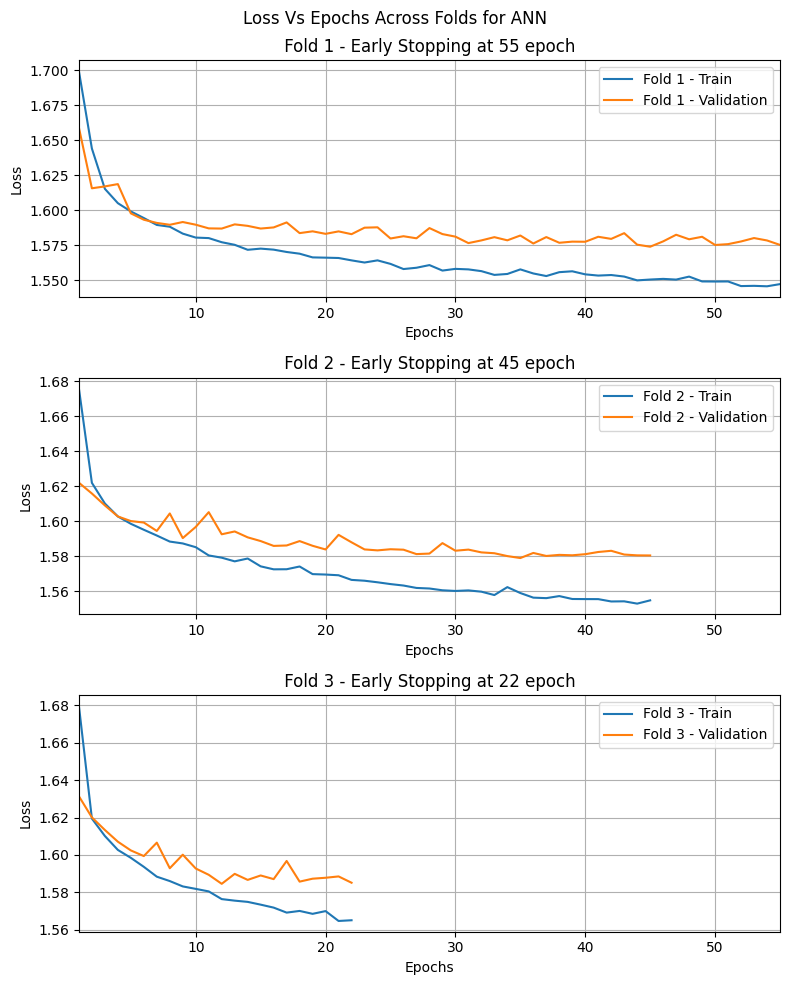

In [37]:
import matplotlib.pyplot as plt

# Assuming you have k_folds, n_epochs, and kf_losses defined

# Set up the subplots
fig, axes = plt.subplots(nrows=k_folds, ncols=1, figsize=(8, 10))
fold = 0 
max_epoch_length = np.array(epoch_end).max() + 1 

fig.suptitle('Loss Vs Epochs Across Folds for ANN')
while fold < k_folds:
    # Plot in the first subplot
    nulls_to_pad = max(0, max_epoch_length - len(kf_losses['train'][fold]))
    
    train_list = kf_losses['train'][fold] + [None] * nulls_to_pad
    val_list = kf_losses['val'][fold] + [None] * nulls_to_pad

    axes[fold].plot(range(1, max_epoch_length+1), train_list , label=f'Fold {fold + 1} - Train')
    axes[fold].plot(range(1, max_epoch_length+1), val_list, label=f'Fold {fold + 1} - Validation')
    axes[fold].set_title(f' Fold {fold+1} - Early Stopping at {epoch_end[fold]+1} epoch ')
    axes[fold].set_xlabel('Epochs')
    axes[fold].set_ylabel('Loss')
    axes[fold].legend()
    axes[fold].grid(True)
    axes[fold].set_xlim(1, max_epoch_length)
    fold+=1
    

# Adjust layout for better spacing
plt.tight_layout()


plt.savefig('Plots/ANN/ANN_Loss_Vs_Epoch.jpg', format='jpg', dpi=300)


# Show the plots
plt.show()


Precision Scores for the 3 folds: [0.8747425364793575, 0.870758713759512, 0.8664863452050419]
Recall Scores for the 3 folds: [0.8742, 0.8705, 0.8668]
F1 Scores for the 3 folds: [0.8735591787583012, 0.8693041947741021, 0.8652267361457929]


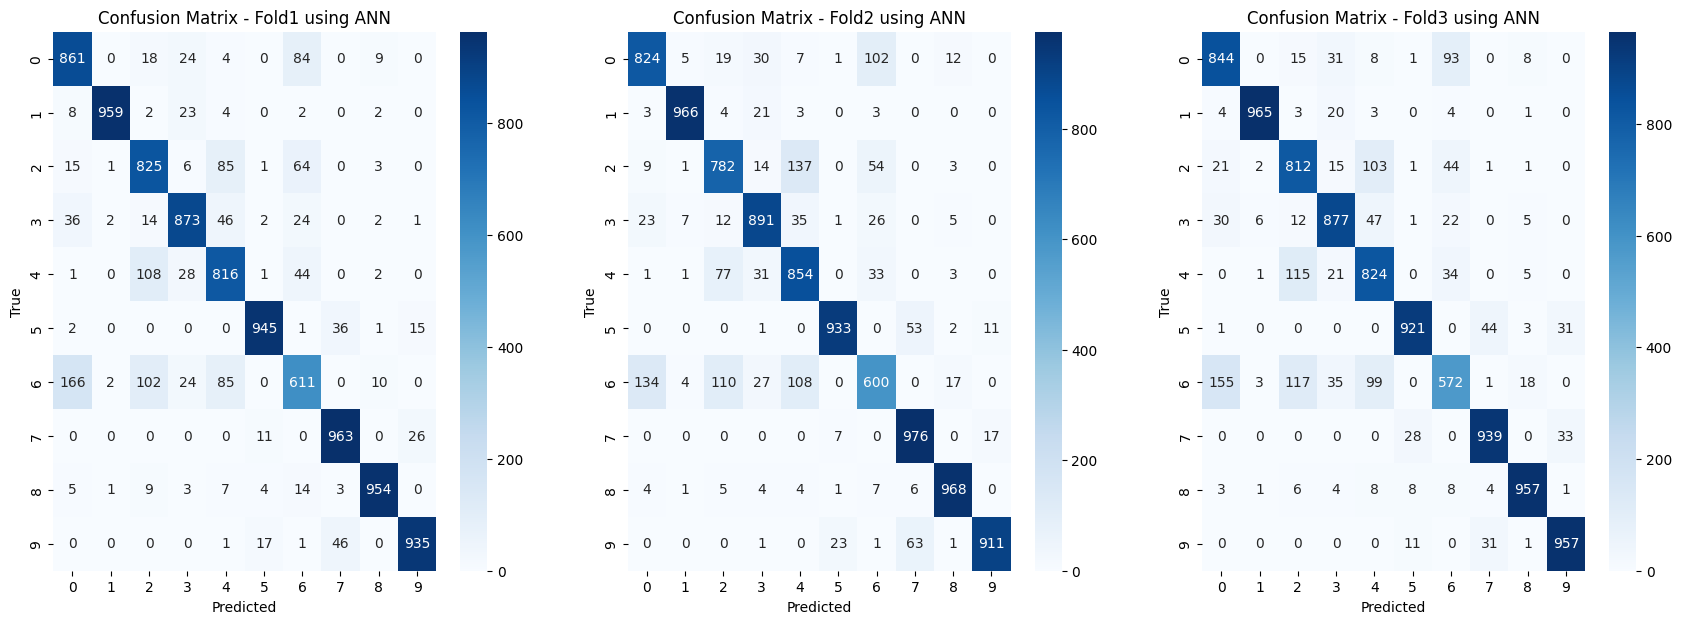

In [38]:
## Evaluation scores
precision_list = []
recall_list = []
f1_list = []
confusion_matrices = []

model = ANN()
checkpoints = ['best_model_0.pth', 'best_model_1.pth', 'best_model_2.pth']

for checkpoint in checkpoints:
    model.load_state_dict(torch.load('Best_Models/ANN/' + checkpoint))
    model.eval()
    
    # Lists to store results from each batch
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calculate metrics for the current checkpoint
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    confusion_matrices.append(confusion_matrix_result)

    # Print or use the results as needed
print("Precision Scores for the 3 folds:", precision_list)
print("Recall Scores for the 3 folds:", recall_list)
print("F1 Scores for the 3 folds:", f1_list)


fig, axes = plt.subplots(nrows=1, ncols=len(checkpoints), figsize=(21, 7))  # Increased figure size for better visualization

# Loop through the confusion matrices and plot a heatmap for each checkpoint
for i, confusion_matrix_result in enumerate(confusion_matrices):
    class_labels = [str(label) for label in range(len(confusion_matrix_result))]
    
    # Create a heatmap using seaborn with integer formatting
    sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    
    axes[i].set_title(f'Confusion Matrix - Fold{i+1} using ANN')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')



# Save the figure
plt.savefig('Plots/ANN/Confusion_Matrix_ANN.jpg', format='jpg', dpi= 300)

plt.show()


### CNN (Convolution Neural Network)

In [39]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [40]:
# K-fold cross-validation loop
n_epochs = 50
epoch_end = []
kf_losses = {'train': [[] for _ in range(k_folds)], 'val': [[] for _ in range(k_folds)]}
kf_accuracy = {'train': [[] for _ in range(k_folds)], 'val': [[] for _ in range(k_folds)]} #Accuracy dictionary 

for fold, (train_indices, val_indices) in enumerate(kf.split(full_train_dataset)):
    train_fold_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
    val_fold_dataset = torch.utils.data.Subset(full_train_dataset, val_indices)

    train_fold_loader = DataLoader(train_fold_dataset, batch_size=64, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=64, shuffle=False)

    # Instantiate the model, loss function, and optimizer
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = {'train': [], 'val': []}

    patience = 10
    counter = 0 
    best_validation_loss = float('inf')  


    for epoch in range(n_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0

        for images, labels in train_fold_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_accuracy = train_correct / train_total    
        average_train_loss = epoch_loss / len(train_fold_loader)
        epoch_losses['train'].append(average_train_loss)

        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        

        with torch.no_grad():
            for images, labels in val_fold_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()


            val_accuracy = val_correct / val_total

            average_val_loss = val_loss / len(val_fold_loader)
            epoch_losses['val'].append(average_val_loss)

        if average_val_loss < best_validation_loss:
            best_validation_loss = average_val_loss
            k = 'Best_Models/CNN/'+'best_model_' + str(fold)
            torch.save(model.state_dict(), f'{k}.pth')
            counter = 0 
        else:
            counter +=1 
        

        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            epoch_end.append(epoch)
            break

        if (epoch+1) == n_epochs:
            epoch_end.append(epoch)


        print(f'Fold {fold + 1}, Epoch {epoch + 1}/{n_epochs}, Train Loss: {average_train_loss:.4f}, Train accuracy: {train_accuracy:.4f},  Val Loss: {average_val_loss:.4f},  Validation accuracy: {val_accuracy:.4f}, Counter: {counter}')

    kf_losses['train'][fold] = epoch_losses['train']
    kf_losses['val'][fold] = epoch_losses['val']

Fold 1, Epoch 1/50, Train Loss: 1.6924, Train accuracy: 0.7729,  Val Loss: 1.6494,  Validation accuracy: 0.8135, Counter: 0
Fold 1, Epoch 2/50, Train Loss: 1.6381, Train accuracy: 0.8234,  Val Loss: 1.6013,  Validation accuracy: 0.8616, Counter: 0
Fold 1, Epoch 3/50, Train Loss: 1.5958, Train accuracy: 0.8662,  Val Loss: 1.5936,  Validation accuracy: 0.8675, Counter: 0
Fold 1, Epoch 4/50, Train Loss: 1.5806, Train accuracy: 0.8810,  Val Loss: 1.5723,  Validation accuracy: 0.8891, Counter: 0
Fold 1, Epoch 5/50, Train Loss: 1.5670, Train accuracy: 0.8951,  Val Loss: 1.5777,  Validation accuracy: 0.8835, Counter: 1
Fold 1, Epoch 6/50, Train Loss: 1.5635, Train accuracy: 0.8981,  Val Loss: 1.5720,  Validation accuracy: 0.8893, Counter: 0
Fold 1, Epoch 7/50, Train Loss: 1.5555, Train accuracy: 0.9062,  Val Loss: 1.5613,  Validation accuracy: 0.8989, Counter: 0
Fold 1, Epoch 8/50, Train Loss: 1.5500, Train accuracy: 0.9119,  Val Loss: 1.5586,  Validation accuracy: 0.9034, Counter: 0
Fold 1, 

In [41]:
# Testing the model
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNN()
test_accuracy_list = []
checkpoints = ['best_model_0.pth', 'best_model_1.pth', 'best_model_2.pth']
for checkpoint in checkpoints:
    model.load_state_dict(torch.load('Best_Models/CNN/' + checkpoint))
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_accuracy_list.append(test_accuracy)

In [42]:
dict_accuracy = {'1': test_accuracy_list[0], '2': test_accuracy_list[1], '3': test_accuracy_list[2], 'Mean': np.array(test_accuracy_list).mean(), 'Standard Deviation': np.array(test_accuracy_list).std()}
df = pd.DataFrame(list(dict_accuracy.items()), columns=['Fold', 'Test Accuracy'])
df.set_index('Fold')

,Test Accuracy
Fold,
1,0.912800
2,0.912400
3,0.911800
Mean,0.912333
Standard Deviation,0.000411


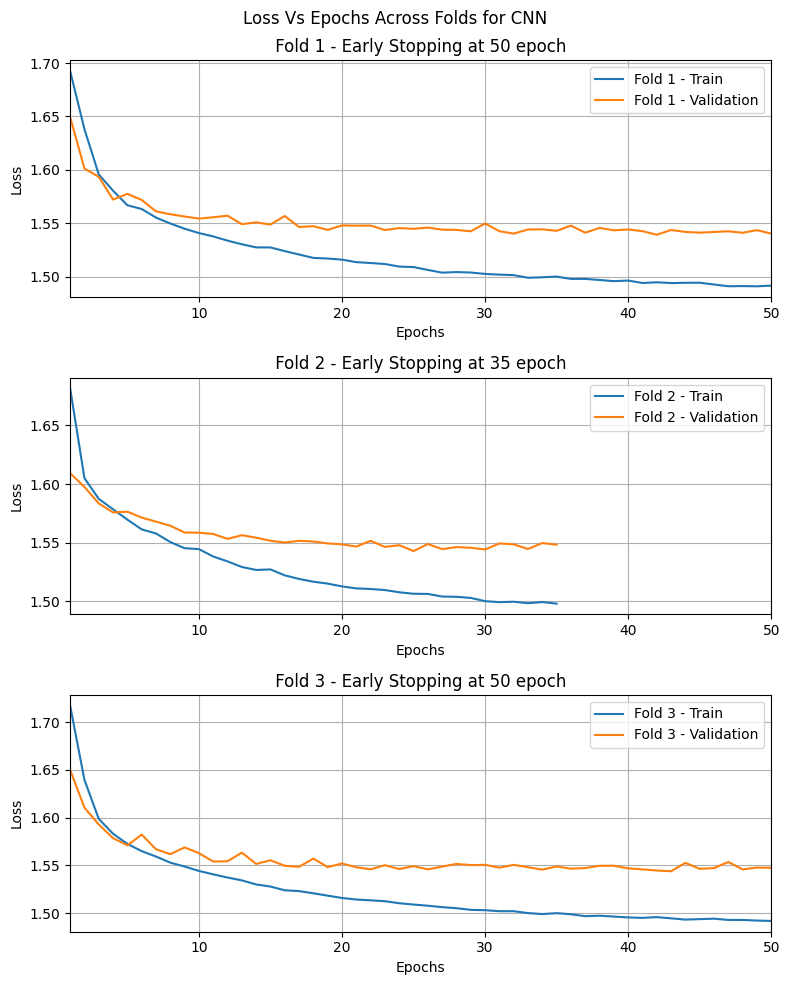

In [43]:
import matplotlib.pyplot as plt

# Assuming you have k_folds, n_epochs, and kf_losses defined

# Set up the subplots
fig, axes = plt.subplots(nrows=k_folds, ncols=1, figsize=(8, 10))
fold = 0 
max_epoch_length = np.array(epoch_end).max() + 1 

fig.suptitle('Loss Vs Epochs Across Folds for CNN')
while fold < k_folds:
    # Plot in the first subplot
    nulls_to_pad = max(0, max_epoch_length - len(kf_losses['train'][fold]))
    
    train_list = kf_losses['train'][fold] + [None] * nulls_to_pad
    val_list = kf_losses['val'][fold] + [None] * nulls_to_pad

    axes[fold].plot(range(1, max_epoch_length+1), train_list , label=f'Fold {fold + 1} - Train')
    axes[fold].plot(range(1, max_epoch_length+1), val_list, label=f'Fold {fold + 1} - Validation')
    axes[fold].set_title(f' Fold {fold+1} - Early Stopping at {epoch_end[fold]+1} epoch ')
    axes[fold].set_xlabel('Epochs')
    axes[fold].set_ylabel('Loss')
    axes[fold].legend()
    axes[fold].grid(True)
    axes[fold].set_xlim(1, max_epoch_length)
    fold+=1
    

# Adjust layout for better spacing
plt.tight_layout()


# Save the figure
plt.savefig('Plots/CNN/CNN_Loss_Vs_Epoch.jpg', format='jpg', dpi=300)


# Show the plots
plt.show()


Precision Scores for the 3 folds: [0.9124380839677784, 0.9115456835175755, 0.9112369016157136]
Recall Scores for the 3 folds: [0.9128, 0.9124, 0.9118]
F1 Scores for the 3 folds: [0.9124897387434959, 0.9117457717371652, 0.9109262200607824]


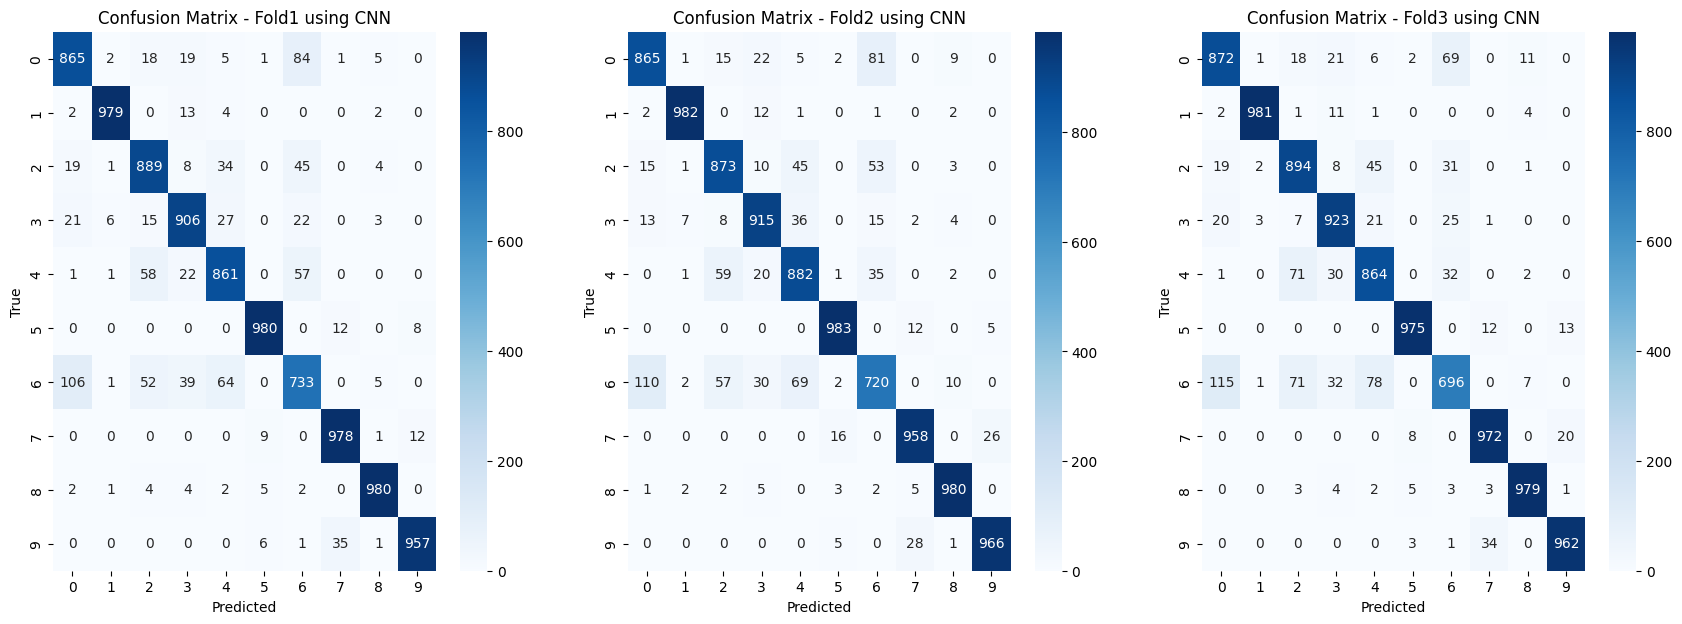

In [44]:
## Evaluation scores
precision_list = []
recall_list = []
f1_list = []
confusion_matrices = []

model = CNN()
checkpoints = ['best_model_0.pth', 'best_model_1.pth', 'best_model_2.pth']

for checkpoint in checkpoints:
    model.load_state_dict(torch.load('Best_Models/CNN/' + checkpoint))
    model.eval()
    
    # Lists to store results from each batch
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calculate metrics for the current checkpoint
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    confusion_matrices.append(confusion_matrix_result)

    # Print or use the results as needed
print("Precision Scores for the 3 folds:", precision_list)
print("Recall Scores for the 3 folds:", recall_list)
print("F1 Scores for the 3 folds:", f1_list)


fig, axes = plt.subplots(nrows=1, ncols=len(checkpoints), figsize=(21, 7))  # Increased figure size for better visualization

# Loop through the confusion matrices and plot a heatmap for each checkpoint
for i, confusion_matrix_result in enumerate(confusion_matrices):
    class_labels = [str(label) for label in range(len(confusion_matrix_result))]
    
    # Create a heatmap using seaborn with integer formatting
    sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    
    axes[i].set_title(f'Confusion Matrix - Fold{i+1} using CNN')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')



# Save the figure
plt.savefig('Plots/CNN/Confusion_Matrix_CNN.jpg', format='jpg', dpi=300)

plt.show()
